# Smoothly Interpolating Shortest Path and Resistance Distances

The "Forest Distances" i.e. Regularized Laplacian Kernels

In [68]:
import networkx as nx
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# from pydlc import dense_lines
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.spatial.distance import squareform, pdist
from scipy.sparse.csgraph import (
    minimum_spanning_tree, 
    csgraph_from_dense, 
    breadth_first_tree, 
    shortest_path
)
# from scipy.stats import Covariance, multivariate_normal, percentileofscore
from scipy.stats import Covariance, multivariate_normal, percentileofscore

from scipy.special import softmax
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler,normalize

from functools import partial
from affinis.plots import hinton
from affinis.distance import generalized_graph_dists

from affinis.distance import adjusted_forest_dists,generalized_graph_dists, _prox_to_dists
from cycler import cycler
from scipy.integrate import trapezoid,cumulative_trapezoid
from tqdm.autonotebook import tqdm, trange
from itertools import count, cycle, islice
from affinis.sample import _random_cut, _random_bridge
from affinis.utils import _e_to_ij, _std_incidence_vec
from itertools import count
from affinis.sample import _random_tree_jump
from affinis.proximity import forest
from functools import cache
from bidict import bidict
from affinis.distance import _prox_to_dists
from affinis.distance import adjusted_forest_dists, generalized_graph_dists
from scipy.sparse import coo_array, csr_array
from toolz.curried import groupby, mapcat, sliding_window, flip
from itertools import combinations


rng = np.random.default_rng(42)
sns.set_theme(style='white')

In [69]:
def f_beta(beta, p,r):
    return (1+beta**2)*(p*r)/(p*beta**2+r)
    
def prox_to_adj(prox): 
    Kii = np.diag(np.diag(prox))

    A_est = prox - Kii
    D_est = np.diag(A_est.sum(axis=0))
    L_est = D_est - A_est
    
    return A_est, D_est, L_est

def prox_to_edgeprob(prox):
    A_est ,D_est,L_est = prox_to_adj(prox)
    scores = squareform(A_est, checks=False)
    return squareform(A_est, checks=False)
    # return percentileofscore(scores, scores, kind='strict')/100.
    # return np.exp(-squareform(A_est, checks=False)/A_est.mean())

def norm_adj(prox): 
    
    A_est ,D_est,L_est = prox_to_adj(prox)

    #normalize
    An_est = np.diag(np.sqrt(1/A_est.sum(axis=0)))@A_est@np.diag(np.sqrt(1/A_est.sum(axis=0)))
    An_est = np.nan_to_num(np.maximum(An_est, An_est.T))
    return An_est

def norm_alt(A):
    a_ii = np.diag(A)
    
    return A/outer(np.multiply, np.sqrt(a_ii))

# def forest(L, beta=1):
#     return np.linalg.inv(np.eye(L.shape[0])+beta*L)

# def interp_dist(L, beta=1):
#     Q = forest(L, beta)
#     norm = np.sqrt(np.multiply.outer(q_ii:=np.diag(Q), q_ii))
#     return -np.log(Q/norm)

def outer(f, a):
    return f.outer(a,a)

def sq(A):
    return squareform(A, checks=False)


In [172]:
n_authors=25
author_idx = pd.CategoricalIndex((f'author_{i:>02}' for i in range(1,n_authors+1)))

# friendships = nx.random_internet_as_graph(n_authors)
# friendships = nx.random_graphs.barabasi_albert_graph(n_authors, 2)
friendships = nx.line_graph(nx.random_tree(len(author_idx)+1, seed=4)) # real events... what "happens" as evidence of a relationship

G = nx.relabel.relabel_nodes(nx.convert_node_labels_to_integers(friendships),dict(zip(range(n_authors),author_idx.categories.tolist())))  # inferred structure

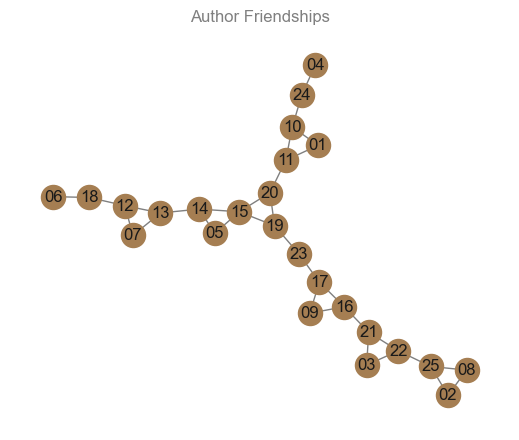

In [173]:
def draw_G(G):
    
    f = plt.figure(figsize=(5,4)).patch.set_alpha(0.)
    pos=nx.layout.kamada_kawai_layout(G)
    nx.draw(G, pos=pos, 
            node_color='xkcd:puce', edge_color='grey')
    nx.draw_networkx_labels(G, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in G})
    plt.title('Author Friendships', color='grey')
    return f, pos
f,pos = draw_G(G)

/tmp/ipykernel_397987/2168502477.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


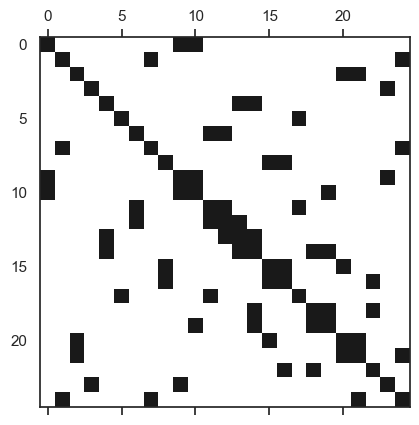

In [174]:
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).todense()
plt.spy(L)
# np.asarray(A)

<Axes: >

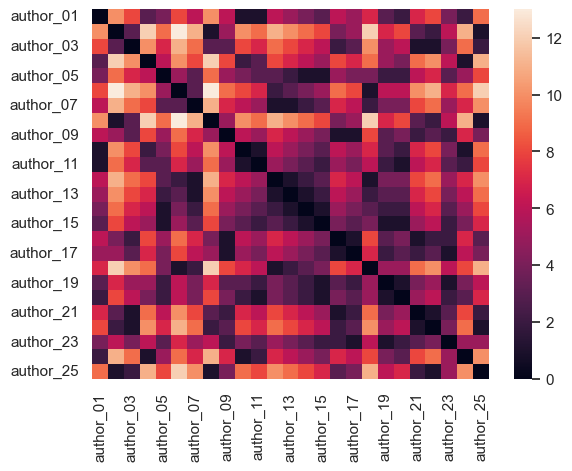

In [175]:
ap_sp = pd.DataFrame.from_dict({k:v for k,v in nx.all_pairs_shortest_path_length(G)}).sort_index()
sns.heatmap(ap_sp)
# sns.heatmap(squareform(prox_to_edgeprob(1-np.log(ap_sp+1).values)))
# -np.log(ap_sp+1)

In [176]:
x = np.logspace(-2,2)
ys = np.vstack([squareform(forest(nx.laplacian_matrix(G), beta=i), checks=False) for i in x])
# ys = np.vstack([prox_to_edgeprob(forest(nx.laplacian_matrix(G), beta=i)) for i in x])

ys.shape

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(50, 300)

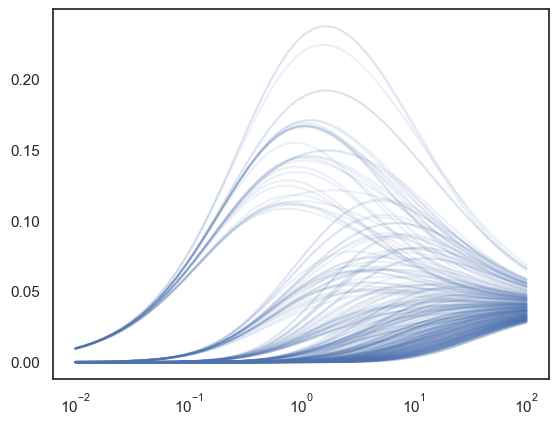

In [177]:
plt.plot(x, ys, color='b', alpha=.1);
# plt.yscale('log')
plt.xscale('log')

In [178]:

# im = dense_lines(ys.T,x=x, cmap='cividis', ny=50, norm=LogNorm())
# plt.yscale('log')
# plt.colorbar(im)
# x

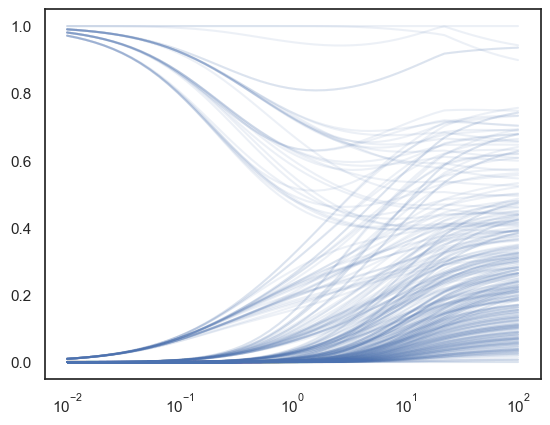

In [179]:
def minmax(x, axis=None): 
    return np.subtract(x,x.min(axis=axis))/np.subtract(x.max(axis=axis),x.min(axis=axis))

plt.plot(x,minmax(ys.T, axis=0).T, color='b', alpha=0.1);
plt.xscale('log')


## Structure Recovery


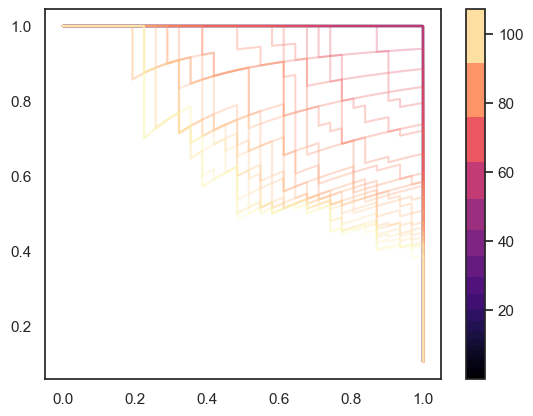

In [180]:
true = squareform(np.diag(np.diag(L))-L)  # True Adjacency
pre,rec,thr = zip(*map(partial(precision_recall_curve, true), ys))

color = plt.cm.magma(np.linspace(0,1,x.shape[0]))
for p,r,c in zip(pre,rec, color):
    plt.plot(r,p, color=c, alpha=.3)
    
plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax = plt.gca(), values=x )
# print([i[[0,-1]] for i in thr])

## Generate Data 

In [188]:
# rng = np.random.default_rng()

# cov = Covariance.from_precision(np.eye(n_authors) + L)
# X = multivariate_normal(cov=cov).rvs(200) < -0.95


def sim_papers(n_weeks, L, jumps_param=0.1): 
    Arw = ((L/np.diag(L)).pipe(lambda df: np.diag(np.diag(df))-df)*0.5)
    def sim_week(): 
        n_jumps = rng.geometric(jumps_param)
        first = rng.multinomial(1,starting:=np.ones(n_authors)/n_authors) 
        # second = (rng.random()>0.5)*rng.multinomial(1,starting)  # maybe
        infected = first #| second
        for jump in range(n_jumps):
            # print((Arw@infected>1).sum(), infected)
            infected = infected | rng.binomial(1, Arw@(infected/infected.sum()))
        return infected


    yield from (sim_week() for i in range(n_weeks))

X = np.vstack(list(sim_papers(50, pd.DataFrame(L, columns=author_idx, index=author_idx))))

4

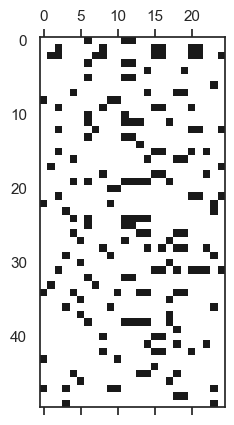

In [189]:
plt.spy(X)
rng.geometric(0.1)

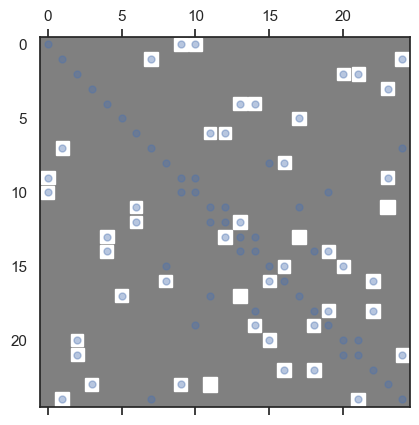

In [190]:
def sinkhorn(p, i=0, err=1e-6, it_max=1000):
    marg_sum = p.sum(0)
    if np.std(marg_sum) < err:
        return np.maximum(p, p.T)
    elif i > 1000:
        import warnings
        warnings.warn("sinkhorn iterations did not converge...", RuntimeWarning)
        return p
    else:
        return sinkhorn((p / marg_sum).T, i=i + 1)
    


def coocur_prob(X, pseudocts=0.): 
    cts = X.T@X + pseudocts 
    tot = X.shape[0] + 2*pseudocts
    return cts/tot

# def cond_prob(X, pseudocts=0.): 
#     cts = X.T@X + pseudocts
#     tot = X.sum(axis=0)+2
#     return cts/tot

def marginal_cts(X): 
    return X.sum(axis=0), (1-X).sum(axis=0)
def marginal_prob(X): 
    return [ct/X.shape[0] for ct in marginal_cts(X)]

def contingency_cts(X): 
    both = sq(X.T@X)
    one = sq(X.T@(1-X))
    other = sq((1-X).T@X)
    neither = sq((1-X).T@(1-X))
    return neither, one, other, both

def contingency_prob(X, pseudocts=0.):
    cts = np.vstack(contingency_cts(X))+pseudocts
    return [ct for ct in cts/(X.shape[0]+pseudocts*2)]

def binary_contingency(X):
    n = X.shape[0]
    both = coocur_prob(X) #np.multiply.outer(X, X).mean(axis=2).mean(axis=0)
    neither = coocur_prob(1-X)#np.multiply.outer(~X, ~X).mean(axis=2).mean(axis=0)
    one = (X.T@(1-X)+1)/(n+2)#np.logical_and.outer(X, ~X).mean(axis=2).mean(axis=0)
    other = one.T
    return neither, one, other, both


def odds_ratio(X, pseudocts=0.):
    a,b,c,d = contingency_prob(X, pseudocts=pseudocts)
    return sq(a*d/(b*c))+np.eye(X.shape[1])


def MI_binary(X, pseudocts=0.):
    """ Mutual Information (e.g. for Chow-Liu Trees)
    """
    Pxy = np.array(contingency_prob(X, pseudocts=pseudocts))
    
    # Pxy = np.vstack([sq(i) for i in cond_table])
    yes, no = marginal_prob(X)
    
    # print(Pxy.sum(axis=1))
    PxPy = np.vstack(
        [sq(np.multiply.outer(a,b)) for a,b in 
         [(no, no), (yes, no), (no, yes), (yes, yes)]]
    )
    entropy = -np.vstack([
        x*np.log(x)
        for x in (yes,no)
    ]).sum(axis=0)
    
    MI_pairs = (Pxy*np.log(Pxy) - Pxy*np.log(PxPy)).sum(axis=0)
    return sq(MI_pairs) + np.diag(entropy)
    # return sq(entropy(Pxy, PxPy))

def chow_liu(X, pseudocts=0.): 
    # return sq(sq(minimum_spanning_tree(-MI_binary(X)).todense()))
    return sq(sq(minimum_spanning_tree(np.exp(-(MI_binary(X, pseudocts=pseudocts)))).todense()))
    


def yule_y(X, pseudocts=0.):
    a,b,c,d = contingency_prob(X, pseudocts=pseudocts)
    return sq(((ad:=np.sqrt(a*d))-(bc:=np.sqrt(b*c)))/(ad+bc))
    # return ((sor:=np.sqrt(OR))-1)/(sor+1)
    # return ((ad:=np.sqrt(both*neither))-(bc:=np.sqrt(one*other)))/(ad+bc)
    
def yule_q(X, pseudocts=0.):
    a,b,c,d = contingency_prob(X, pseudocts=pseudocts)
    return sq(((ad:=a*d)-(bc:=b*c))/(ad+bc))

def ochiai(X, pseudocts=0.): 
    """AKA cosine similarity on binary sets
    
    This code illustrates the idea that we can interpret it as a conditional probability: 
    The "exposure" of pairwise co-occurrences can't be larger than the sample size, 
    so instead we approximate it as a psuedo-variable  having the geometric average of the 
    two original exposure rates $\sqrt{X_1X_2}$
    
    This interpretation has a nice side-effect of letting us "smooth" the measure with 
    laplace/additive pseudocounts on each bernoulli(-ish) "co-occurrence variable". 
    """
    # I = np.eye(X.shape[-1])
    co_occurs = sq(X.T@X) + pseudocts
    exposures = X.sum(axis=0)
    pseudo_exposure = np.sqrt(outer(np.multiply, exposures)) + 2*pseudocts
    return sq(co_occurs)/pseudo_exposure + np.eye(X.shape[1])

def resource_project(X): 
    """bipartite project due to Zhao et al. 
    
    Really just a step of sinkhorn-knopp on the bipartite adjacency
    https://doc.rero.ch/record/8503/files/zhang_bnp.pdf
    """
    P = ((X.T)/(X.sum(axis=1)))@((X)/(X.sum(axis=0)))
    return np.maximum(P,P.T) 

# def yule_q(
# norm_adj(cooc)
# sns.heatmap(-np.log(ochiai(X)))
hinton(chow_liu(X, pseudocts=1))
# hinton(MI_binary(X))
# hinton(sq(sq(minimum_spanning_tree(np.exp(-(MI_binary(X, pseudocts=)))).todense())))

# hinton(minimum_spanning_tree(np.exp(-np.nan_to_num(MI_binary(X)))).todense())
plt.spy(L, marker='.', alpha=0.4)
# hinton(ochiai(X, pseudocts=0.1))
# np.isna
# np.multiply.outer((1-X).sum(axis=0), X.sum(axis=0))/X.shape[0]**2

<Axes: ylabel='Count'>

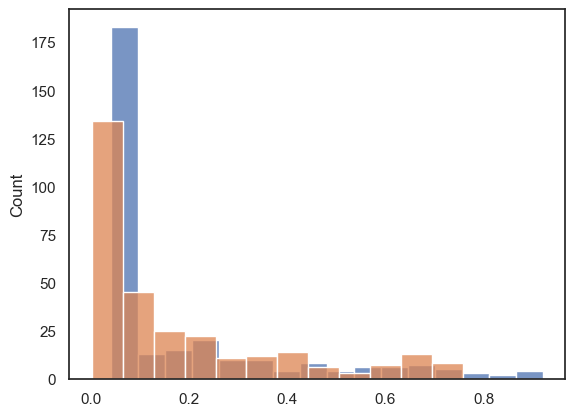

In [191]:
norm_alt((X.T@X)/X.shape[0]), ochiai(X)

Xstack = np.vstack([X, -X])#.mean(axis=0)
Xstack.mean(axis=0)


sns.histplot(sq(ochiai(X, pseudocts=0.5)))
sns.histplot(sq(norm_alt(forest(L, beta=5))))

## Noisy Structure Recovery (Inverse Problem)

In [192]:
baselines = {
    # 'co-occur':sq(coocur_prob(X, pseudocts=1.)),
    'cosine': sq(ochiai(X, pseudocts=1.)),
    'sinkhornOTP': sq(sinkhorn(coocur_prob(X, pseudocts=1.), err=1e-8)),
    'resourceProj': sq(resource_project(X)),
    # 'odds-ratio': sq(odds_ratio(X, pseudocts=1)),
    'yuleQ':sq(yule_q(X, pseudocts=1.)),
    # 'yuley': prox_to_edgeprob(yule_y(X)),
    'mutualinfo': sq(MI_binary(X, pseudocts=1.)),
    # 'yuleq':np.arcsin(prox_to_edgeprob(yule_y(X)))/np.pi +0.5,
    'glasso': -squareform(GraphicalLassoCV().fit(X).get_precision(), checks=False)



    # 'sinkhorn-cos': squareform(sinkhorn(cos - np.diag(np.diag(cos)), err=1e-8)),
}

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


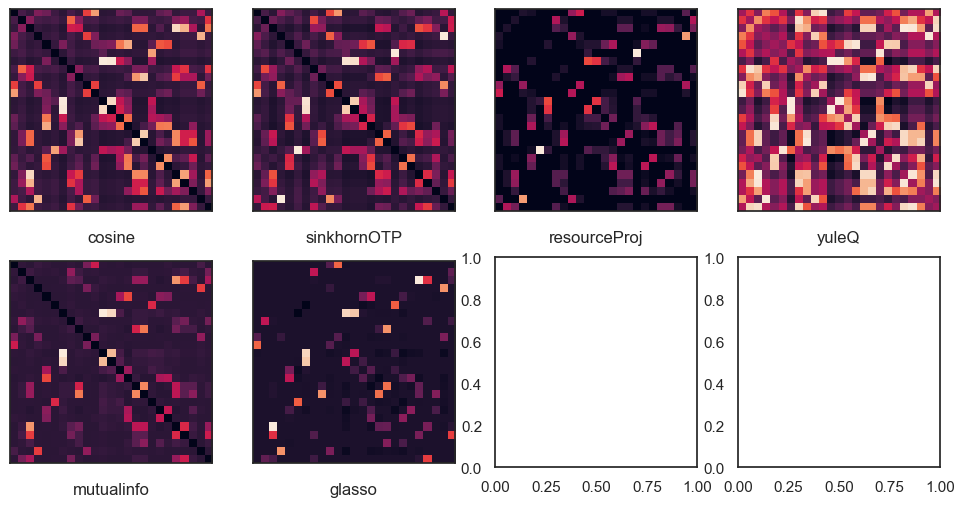

In [193]:
f,axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

for n, (lab, Aest) in enumerate(baselines.items()): 
    ax = axs.flatten()[n]
    ax.imshow(squareform(Aest))
    ax.set_xlabel(lab)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

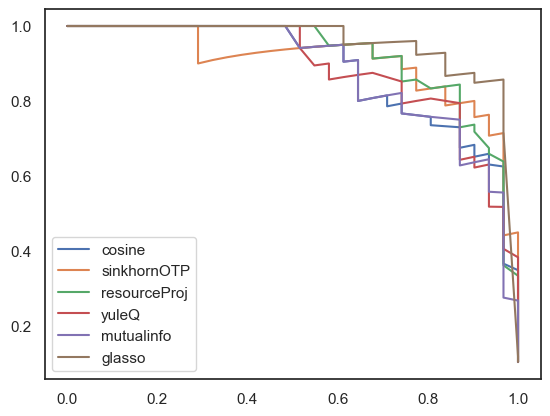

In [194]:
for lab,Aest in baselines.items():
    
    p,r,t = precision_recall_curve(true, Aest)
    # plt.plot(np.tanh(r-p),np.tanh(r+p), label=lab)
    plt.plot(r,p,label=lab)
    
plt.legend()

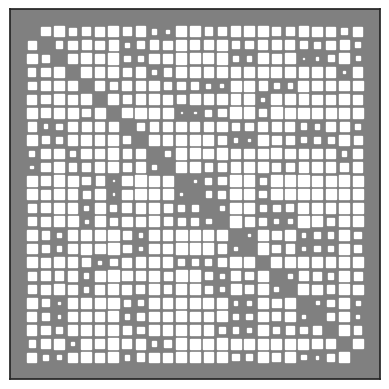

In [195]:
def approx_dists(X): 
    Q_apprx = sinkhorn(coocur_prob(X, pseudocts=1.))
    norm = np.sqrt(np.multiply.outer(q_ii:=np.diag(Q_apprx), q_ii))
    return -np.log(Q_apprx/norm)

hinton(approx_dists(X))

In [196]:
papers=pd.DataFrame(X, columns=author_idx)

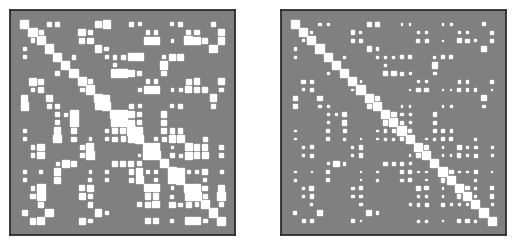

In [197]:


sp_papers = csr_array(papers.values)
src,tgt = list(zip(*mapcat(
    flip(combinations,2), 
    map(lambda pair: sp_papers.indices[pair[0]:pair[1]], 
        sliding_window(2,sp_papers.indptr)
       )
)))
shap = (len(tgt), n_authors)
def stack_with_negation(B): 
    return np.vstack((B,-B))
B_papers = pd.DataFrame(
    ( 
        coo_array((np.ones(shap[0]), (np.arange(shap[0]),tgt)), shape=shap)
        -
        coo_array((np.ones(shap[0]), (np.arange(shap[0]),src)), shape=shap)
    ).todense(), columns=author_idx
)

Ws = np.diag(np.array(list(mapcat(lambda i: (comb:=i*(i-1)//2)*[i], papers.sum(axis=1).tolist()))))
L_papers=(B_papers.T@Ws@B_papers)
plt.subplot(121)
hinton(ochiai(papers.values))
plt.subplot(122)
hinton(ochiai(np.abs(B_papers).values))


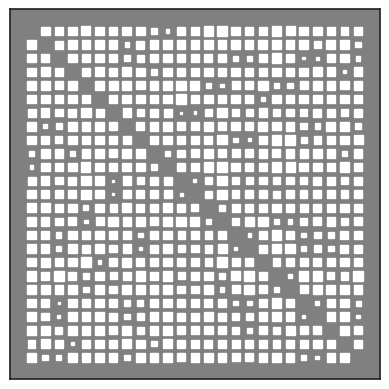

In [198]:
from affinis.utils import sparse_adj_to_incidence
from scipy import sparse as sprs

def norm_B(B): 
    invdeg = 1./np.sqrt(np.abs(B).sum(axis=0))
    return B@np.diag(np.nan_to_num(invdeg, nan=0.))

def norm_diag(L): 
    return (Dinv:=np.diag(np.sqrt(1/np.diag(L))))@L@Dinv

def get_mask(e_pmf,idx):
    return coo_array(squareform(e_pmf)*np.multiply.outer(idx,idx))

Xdf = papers.assign(root=1)
# est_dists = approx_dists(Xdf.values)
MI_df = MI_binary(X, pseudocts=0.2)
# est_dists = np.nan_to_num(MI_df, nan=np.nanquantile(MI_df, 0.5))
est_dists = -np.log(norm_diag(MI_df))
hinton(est_dists)
# 1-np.log(est_dists)

/tmp/ipykernel_397987/672927069.py:7: RuntimeWarning: invalid value encountered in divide
  add_pmf = np.nan_to_num(sq(np.abs(B_obs.T@B_obs).todense()/(X.T@X)))


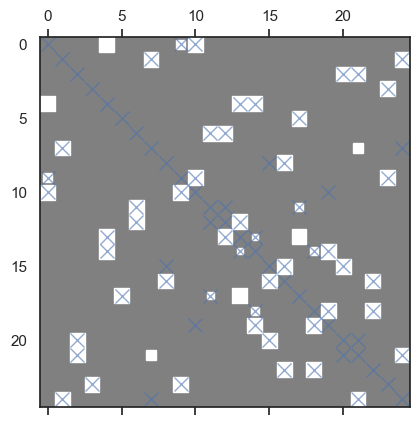

In [199]:
B_obs = sprs.vstack([
    (sparse_adj_to_incidence(minimum_spanning_tree(
        get_mask(sq(est_dists),i)
    ))) for i in papers.values
])

add_pmf = np.nan_to_num(sq(np.abs(B_obs.T@B_obs).todense()/(X.T@X)))
# smooth_pmf = (add_pmf+np.where(add_pmf==0., 1, add_pmf))/(add_pmf.sum())
hinton(squareform(add_pmf))
plt.spy(L, marker='x', alpha=0.6)


matrix([[ 6.,  4., 12.,  5., 13.,  5., 21.,  3.,  7.,  8.,  7., 12., 14.,
         13., 16., 14., 19.,  9., 11., 12., 13., 10.,  7.,  9.,  6.]])

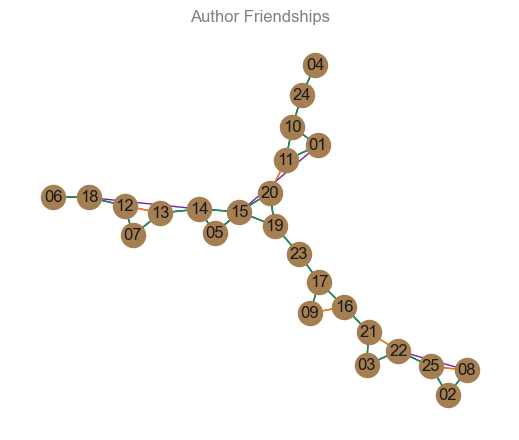

In [200]:
draw_G(G)

nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame((squareform(add_pmf)>0)*sq(sq(~A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:purple', pos=pos
)
nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame((squareform(add_pmf)>0)*sq(sq(A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:emerald', pos=pos
)

nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame(~(squareform(add_pmf)>0)*sq(sq(A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:orange', pos=pos
)

(B_obs.T@B_obs).todense()
np.abs(B_obs).sum(axis=0)
# draw_G(nx.from_pandas_adjacency(pd.DataFrame(squareform(add_pmf), columns=author_idx, index=author_idx)))
# pd.DataFrame(squareform(smooth_pmf), columns=author_idx, index=author_idx)#.astype(int)

In [201]:
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
        )
    ax.legend().set_visible(False)

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]


cosine
 total MCC: 	           0.59


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]


sinkhornOTP
 total MCC: 	           0.57


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2912: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singula

resourceProj
 total MCC: 	           0.41


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2914: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singula

yuleQ
 total MCC: 	           0.61


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2912: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singula

mutualinfo
 total MCC: 	           0.47


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2912: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singula

glasso
 total MCC: 	           0.46


/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cd = integrate.quad(fun, c, d, **kwds)[0]


MST
 total MCC: 	           0.80


([0.0,
  0.8524548698177422,
  0.8321930086916467,
  0.8115994250831611,
  0.7906486023772925,
  0.7693121501434075,
  0.7879232562325217,
  0.0],
 array([0.        , 0.16666667, 0.25      , 0.28571429, 0.33333333,
        0.5       , 1.        , 1.01      ]))

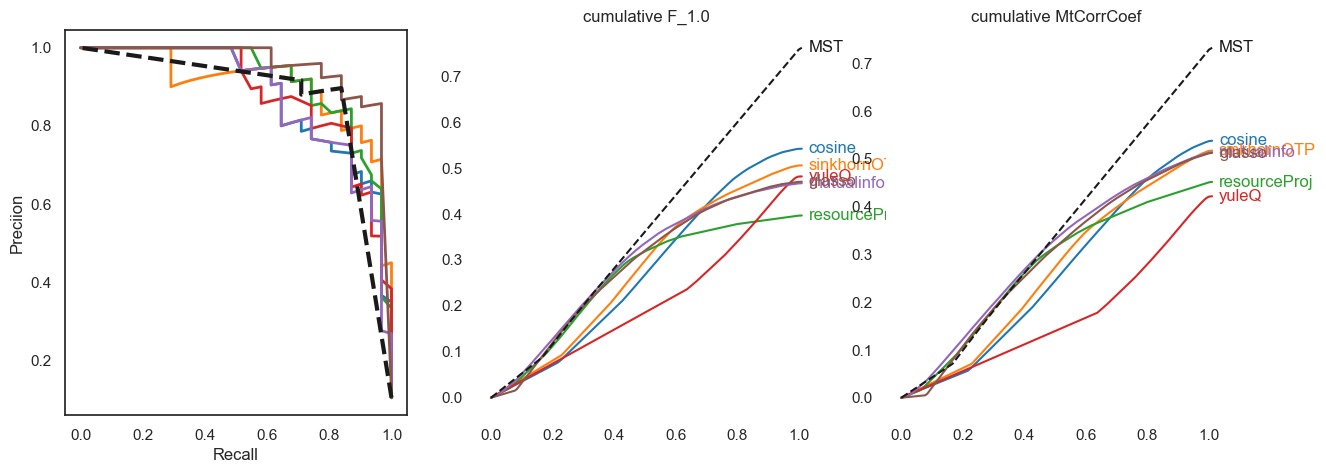

In [298]:
# plt.plot(r,p, color='r', ls=':', zorder=0, alpha=0.5, label='pure cosine')
# plt.plot(r,p, color='g', ls=':', zorder=0, alpha=0.5, label='Sinkhorn OT')
from sklearn.metrics import matthews_corrcoef
# from scipy.stats import multivariate_normal, beta
from scipy import stats
from scipy.interpolate import interp1d
def thres_expect(dist, x_thres, score):
    return dist.expect(interp1d(x_thres,score, bounds_error=False, kind='next'))
stats.beta.expect(
def human_thres_expect(x_thres, score):
    return 0.5*thres_expect(stats.beta(0.5,0.5),x_thres, score)+0.5*thres_expect(stats.beta(2.5,1.7),x_thres,score)
    # return thres_expect(stats.beta(2.5,1.7), x_thres,score)
    
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,5))
# fig.add_subplot(
cmap = plt.get_cmap("tab10")

color_cyc = cycler(color=[cmap(i) for i in range(len(baselines))])
cyc =  color_cyc*cycler(linestyle=['-','--'])
ax1.set_prop_cycle(cyc)
ax0.set_prop_cycle(color_cyc)

beta = 1.

for n,(lab,Aest) in enumerate(baselines.items()):
    p,r,t = precision_recall_curve(true, Aest, drop_intermediate=True)
    
    ax0.plot(r,p, label=lab, lw=2)
    # ax1.plot(minmax(t),np.array([p[:-1],r[:-1]]).T, lw=2, label='precision', alpha=0.2)
    x_thres = np.append(minmax(t), 1.01)
    mcorr = [matthews_corrcoef(true, minmax(Aest)>=i) for i in x_thres]
    print(
        f'{lab}'
        # f'\n total F_{beta}: \t{human_thres_expect(x_thres, f_beta(beta,p,r)):>15.2f}'
        f'\n total MCC: \t{human_thres_expect(x_thres, mcorr):>15.2f}'
        # f'\n total F_{beta}: \t{trapezoid(f_beta(beta, p,r), x=x_thres):>15.2f}'
        # f'\n total MCC: \t{trapezoid(mcorr, x=x_thres):>15.2f}'
    )

    # ax1.plot(x_thres, f_beta(beta, p,r))
    ax1.plot(x_thres, cumulative_trapezoid(f_beta(beta, p,r), x=x_thres, initial=0.), 
             color=cmap(n), ls='-', label=lab)
    ax2.plot(x_thres, cumulative_trapezoid(mcorr, x=x_thres, initial=0.), 
             color=cmap(n), ls='-', label=lab)

# p,r,t = precision_recall_curve(true, squareform(L_mst.values))
# p,r,t = precision_recall_curve(true, squareform(np.exp(-generalized_graph_dists(np.diag(L_mst.sum())-L_mst, beta=0.1)), checks=False))
p,r,t = precision_recall_curve(true, add_pmf)
# p,r,t = precision_recall_curve(true, squareform(squareform(np.array(hist).mean(axis=0)), checks=False))

ax0.plot(r,p,'--',label='MST Observations', lw=3, color='k')
ax0.set(ylabel='Preciion', xlabel='Recall')

# ax0.legend()
# ax1.plot(minmax(t),np.array([p[:-1],r[:-1]]).T,label='MST Observations', lw=3, color='k', alpha=0.2)
x_thres = np.append(minmax(t), 1.01)
# ax1.plot(x_thres, f_beta(beta, p,r))

mcorr = [matthews_corrcoef(true, minmax(add_pmf)>=i) for i in x_thres]
print(
    f'MST'
    # f'\n total F_{beta}: \t{trapezoid(f_beta(beta, p,r), x=x_thres):>15.2f}'
    # f'\n total MCC: \t{trapezoid(mcorr, x=x_thres):>15.2f}'
    # f'\n total F_{beta}: \t{human_thres_expect(x_thres, f_beta(beta,p,r)):>15.2f}'
    f'\n total MCC: \t{human_thres_expect(x_thres, mcorr):>15.2f}'
)
ax1.plot(x_thres, cumulative_trapezoid(f_beta(beta, p,r), x=x_thres, initial=0.), 
         color='k', ls='--', label='MST')
ax1.set_title(f'cumulative F_{beta}')
ax2.plot(x_thres, cumulative_trapezoid(mcorr, x=x_thres, initial=0.), 
         color='k', ls='--', label='MST')
ax2.set_title(f'cumulative MtCorrCoef')
improve_legend(ax1)
improve_legend(ax2)
# pre,rec,thr = zip(*map(partial(precision_recall_curve, true), ys_emp))
# for p,r,c in zip(pre,rec, color):
#     plt.plot(r,p, color=c, alpha=.5, zorder=-1, lw=0.5)
# plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax = plt.gca(), values=x )
# plt.legend()
mcorr, x_thres

0.7691442610463506

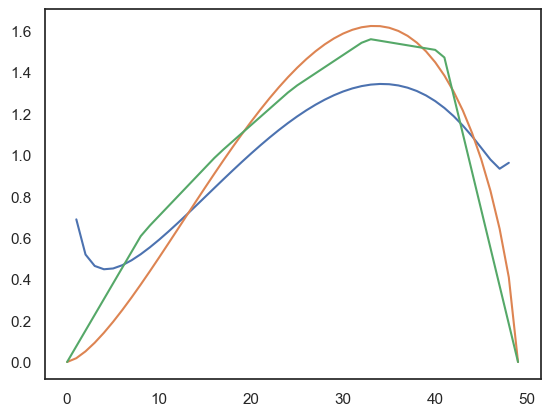

In [292]:
plt.plot(0.3*stats.beta(0.5,0.5).pdf(np.linspace(0,1))
         +0.7*stats.beta(2.5,1.7).pdf(np.linspace(0,1))
        )
plt.plot(stats.beta(2.5,1.7).pdf(np.linspace(0,1)))

# approximate, from this publication on star ratings: 
# https://www.emerald.com/insight/content/doi/10.1108/XJM-10-2020-0171/full/html

plt.plot(np.array([[0.1,1/25.,3/50.,0.2,3/5.][n]*stats.triang(i).pdf(np.linspace(0,1)) for n,i in enumerate(np.linspace(0,1,7)[1:-1])]).sum(axis=0))
np.array([[0.1,1/25.,3/50.,0.2,3/5.][n]*thres_expect(stats.triang(i),x_thres,mcorr) for n,i in enumerate([0.05,0.25,0.5,.75,0.95])]).sum()

# multivariate_normal(cov=forest(L, beta=5.)).logpdf(Xstack/2)  # for co-occurrences
# multivariate_normal(cov=norm_alt(5*L+np.eye(n_authors))).logpdf(np.array(struct.todense())[:,:-1]).sum()  # for interractions
# multivariate_normal(mean=0.0*np.ones(n_authors), cov=norm_alt(5.*L+np.eye(n_authors))).logpdf(np.eye(n_authors))#.sum()  # for interractions

# np.array(struct.todense())[:,:-1]
# plt.plot((np.linspace(0,1)), interp1d(x_thres,mcorr,bounds_error=False)(np.linspace(0,1)))
# multivariate_normal(cov=np.eye(n_authors)).logpdf(np.array(struct.todense())[:,:-1])

## EM Algorithm

gets stuck in local minimum pretty much immediately (nope)...now it loses just like gibbs)

don't forget to add back the "forest" part (i.e. MST with added reg. node. 

In [761]:
# [(n,np.diag(t.L())[-1]) for n,t in enumerate(trees)]  # find where tree split stuff into two 

array([0.82057201, 0.64667362, 0.52641418, 0.53804974, 0.66771939,
       0.8099455 , 0.52390217, 0.82327966, 0.8081585 , 0.72158035,
       0.72367123, 0.82180702, 0.87530349, 0.81670037, 0.72598038,
       0.9682742 , 0.72673574, 0.79901109, 0.71860465, 0.91899172])

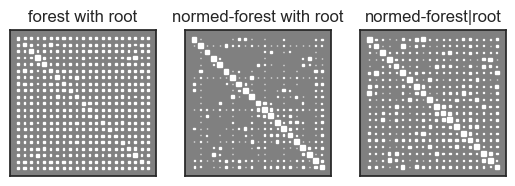

In [738]:
# hinton(adjusted_forest_dists(L))


# Ω=np.linalg.inv(L+np.ones_like(L)/n_authors**2)
# _prox_to_dists(Ω)
# sns.heatmap(1-adjusted_forest_dists(L))

def cond_on_root(cov, c_inv=None, root_loc=-1):
    if c_inv is None: 
        c_inv = np.linalg.pinv(cov)
    c_ir = np.delete(cov[root_loc], [root_loc])
    correction = outer(np.multiply, c_ir)*c_inv[root_loc,root_loc]
    return np.delete(np.delete(cov, root_loc, 1), root_loc, 0) - correction
plt.subplot(131)
hinton(forest(np.array((struct.T@struct).todense())))
plt.title('forest with root')
plt.subplot(132)
hinton(forest(norm_alt(np.array((struct.T@struct).todense()))))
plt.title('normed-forest with root')
plt.subplot(133)
hinton(cond_on_root(forest(norm_alt(np.array((struct.T@struct).todense())), beta=5.), c_inv=norm_alt(np.array((struct.T@struct).todense()))))
plt.title('normed-forest|root')
# np.delete(np.delete((struct.T@struct).todense(),-1,0), -1,1).shape
# L[np.s_[[-1],[-1]]]
cond_on_root(forest(norm_alt(np.array((struct.T@struct).todense())), beta=5.), c_inv=norm_alt(np.array((struct.T@struct).todense()))).sum(axis=1)

[[ 1. -1.  0.  0.  0.  0.]
 [-1.  2.  0. -1.  0.  0.]
 [ 0.  0.  2.  0. -1. -1.]
 [ 0. -1.  0.  2. -1.  0.]
 [ 0.  0. -1. -1.  3.  0.]
 [ 0.  0. -1.  0.  0.  1.]]
[[ 2.  -1.  -1.   0.   0.   0. ]
 [-1.   2.   0.   0.   0.  -1. ]
 [-1.   0.   2.   0.  -1.   0. ]
 [ 0.   0.   0.   0.1  0.  -0.1]
 [ 0.   0.  -1.   0.   1.   0. ]
 [ 0.  -1.   0.  -0.1  0.   1.1]]


0.1

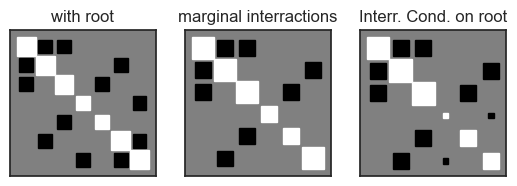

In [825]:
## KINDA..."contracting"? the root node? into a longer edge connecting the two components. 
t=trees[14]
plt.subplot(131)
plt.title('with root')
hinton(t.L())
plt.subplot(132)
plt.title("marginal interractions")
hinton(t.L()[:-1,:-1])
print(np.round(trees[0].L()[:-1,:-1], 2))
plt.subplot(133)
plt.title("Interr. Cond. on root")
# hinton(cond_on_root(t.L()+np.eye(shp:=t.L().shape[0]), c_inv=np.linalg.inv(t.L()+np.ones((shp,shp))/shp**2)))
# print(np.round(cond_on_root(t.L()+np.eye(t.L().shape[0]), c_inv=forest(t.L(), beta=5.)), 2))

def adj_to_lap(A): 
    return np.diag(A.sum(axis=0))-A
hinton(adj_to_lap(-sq(sq(t.L()[:-1,:-1])-sq(outer(np.multiply,t.L()[-1,:-1])*0.1))))
print(adj_to_lap(-sq(sq(t.L()[:-1,:-1])-sq(outer(np.multiply,t.L()[-1,:-1])*0.1))))
1/(5+5)

<Axes: >

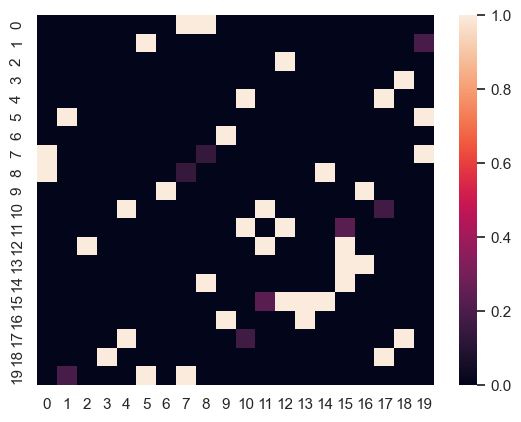

In [806]:
sns.heatmap(-(sq(sq(np.round(np.array((struct.T@struct).todense())/(Xdf.T@Xdf), 2).fillna(0).values)))[:-1,:-1])

In [311]:

def M_step(data, expected_dists, expected_struct):
    B_obs = [
        sparse_adj_to_incidence(
            minimum_spanning_tree(
                get_mask(squareform(expected_dists, checks=False),i)
            )
        ) for i in data
    ]
    B_obs = sprs.vstack(B_obs)#/len(B_obs)
    new_L = (B_obs.T@B_obs).todense()
    # new_A = np.nan_to_num(np.abs(B_obs.T@B_obs).todense()/(data.T@data))
    # np.fill_diagonal(new_A, 0.)
    # new_L = np.diag(new_A.sum(axis=0))-new_A
    # new_L = squareform((new_L+np.where(new_L==0., 1, new_L))/(new_L+1).sum())
    # print(new_L)
    return data, expected_dists, new_L

def E_step(data, expected_dists, expected_struct):
    new_dists = generalized_graph_dists(norm_alt(expected_struct), beta=5.)
    # new_dists = np.exp(-MI_binary(expected_struct, pseudocts=1.))
    # print(new_dists)
    return data, new_dists, expected_struct

def EM(data, expected_dists, expected_struct): 
    X,Q,L = data, expected_dists, expected_struct
    while True: 
        X,Q,L = E_step(*M_step(X,Q,L))
        # yield Q,L
        # X,Q,L = E_step(X,Q,L)
        yield Q,L

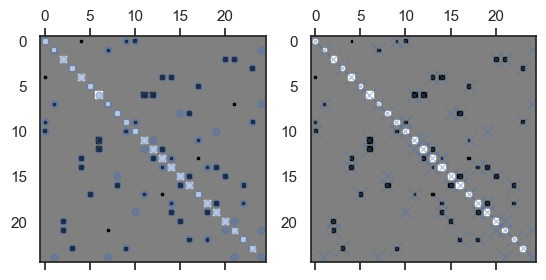

In [313]:
em_gen = EM(papers.values, est_dists, np.exp(-est_dists))
plt.subplot(121)
hinton(next(em_gen)[-1][:-1,:-1])
plt.spy(L, marker='.', alpha=0.4)
plt.subplot(122)
for i in range(10): 
    
    Qk,Lk=next(em_gen)
    # print(Qk)
    # print(multivariate_normal(cov=forest(Lk[:-1,:-1], beta=5.)).logpdf(Xstack/2).sum())
    # print(multivariate_normal(cov=forest(Lk[:-1,:-1], beta=5.)).entropy())
hinton(next(em_gen)[1][:-1,:-1])
plt.spy(L, marker='x', alpha=0.4)

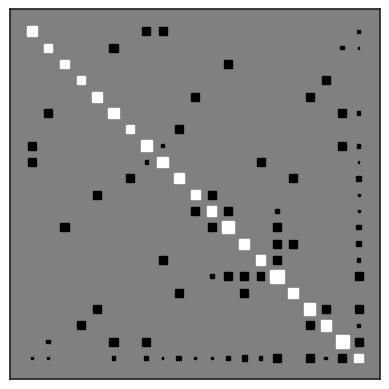

In [679]:
hinton(((next(em_gen)[1])/(Xdf.T@Xdf)).fillna(0).values)

In [285]:

# plt.spy(L, marker='.', alpha=0.4)

we can actually interpret ochiai/cosine as an approximate bayes update. 

Say we observe binary variables A and B, along with others. 

Now, we want a probability of conditional dependence between A and B (does information flow directly between a and b when a and b happen together?). So we want the probability ofand edge $E_{ab}$ being used, given that such an edge had the opportunity to be used. E.g. did two people have a causal interraction to make each other sick, given a time when we know they were both exposed/became sick. 

P(E|O) = P(O|E) * P(E)/P(O)

The denominator is hard, because while we can estimate the frequency of each node as the occurrences/opportunities (i.e. events/exposure), so, n_i/N, we can't use that for an exposure for "number of times an edge between A,B could have been used". If we multiply N(a)\*N(b), then we have the number of _ways_ a or b could be related over all chances, but this won't be a fraction of the number of samples, and could possible be much bigger... so dividing the number of times both _did_ happen together by that number won't get us a probability.  So instead, we fib a bit. 

The number of chances (out of all samples) that a pair had to happen together is somewhere between the chances each had separately. We make a pseudo-variable that uses this fact, but averaging the rates. but we are dealing with probabilities, which are based around "areas" and their ratios. So we want one count, such that watching it with a copy of itself has the same exposure as watching A and B separately. This is exaclty what geometric means are for: 


Then, a point estimate for the probability of an edge occurring is its actual co-ocurrence $n_{a,b}/N$. It's the ratio of  these that give us the Ochiai as a probability: divided by the estimate for the co-ocurrence opportunities 

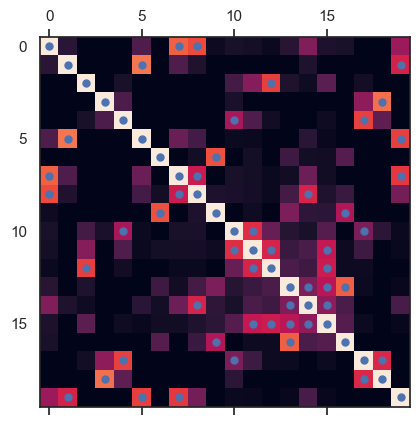

In [580]:
# hinton(next(em_gen)[1])
# next(em_gen)[1]
# papers
# squareform((papers.T@papers).values, checks=False)

def norm_pmf(x):
    return x/x.sum()
(sq(_prox_to_dists((papers.T@papers).values)/papers.shape[0]))
# (sq((papers.T@papers).values))/papers.shape[0]
# hinton(odds_ratio(papers).values)
# np.exp(papers.cov())
def indeps_over_actual(K):
    k_ii = np.diag(K)
    return K/np.sqrt(outer(np.multiply,k_ii))
    # return 
# np.multiply.outer(np.diag(papers.T@papers))
# plt.imshow(((lambda p: p/(1-p))(ochiai(papers.values))))
plt.spy(L, marker='.')
plt.imshow(np.exp(-_prox_to_dists(ochiai(papers.values))))
# 1-(_prox_to_dists(ochiai(papers.values)))

## Gibbs

need: 
- the individual tree estimates (mode is MST, resample with cut+bridge)
- individual trees' forest matrices --> the partition (bridge-possible) edges
- overall "structure" estimate (the edge-mixture model) --> bridge-probabilities


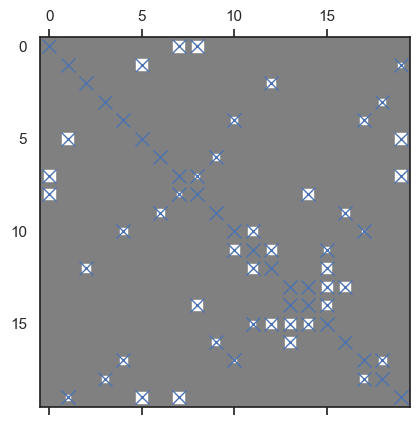

In [651]:

# import static_frame as sf

from typing import NamedTuple
class TreeDistribution(NamedTuple):
    nodes: np.ndarray
    incidence: np.ndarray
    forest: np.ndarray | None
    
    @classmethod
    def from_subset_mode(cls, dists, activation):
        nodes = np.where(activation)[0]
        # print(nodes,dists[nodes][:,nodes])
        incidence = sparse_adj_to_incidence(
            # breadth_first_tree(
                minimum_spanning_tree(np.atleast_2d(dists[nodes][:, nodes])), 
                # len(nodes)-1,
                # directed=False
            # )
        ).todense()
        Q = forest(incidence.T@incidence, beta=1)
        return cls(nodes, incidence, Q)

    
    def upcast_incidence(self, n_cols):
        B=csr_array(self.incidence)
        indices = self.nodes[B.indices]
        return csr_array((B.data, indices, B.indptr), shape=(B.shape[0], n_cols))
    
    # @cache
    def upcast_nodes(self, n_cols): 
        idx = np.zeros(n_cols)
        idx[self.nodes] = 1
        return idx
        # return csr_array((np.ones_like(n),(np.zeros_like(n), n)), shape=(1,n_cols)).todense()[0]
    def L(self): 
        return self.incidence.T@self.incidence
    
    def Lsym(self): 
        # print(np.diag(self.L()))
        return norm_alt(self.L())
    
    def get_edges_idx(self, n_cols):
        nodes = self.upcast_nodes(n_cols)
        return squareform(np.multiply.outer(nodes,nodes), checks=False).astype(bool)
    
    def get_edge_mask(self, n_cols):
        return np.where(self.get_edges_idx(n_cols))[0]
    
    def get_edge_degprior(self): 
        deg = np.diag(self.L())
        # print(deg/deg.sum())
        return sq(outer(np.multiply, deg)/deg.sum())
    
    def get_edges_prob(self, n_cols, degprior=False, pseudocts=0):
        e_idx=self.get_edges_idx(n_cols)  # which edges could have been
        e_prob = -sq(self.L())
        # print( e_prob/e_prob.sum())
        # e_prob = (e_prob+pseudocts)/(e_prob.sum()+2*pseudocts)  # which were vs which could
        # print(e_idx.sum(), e_prob.sum())
        # all_e_idx=self.get_edges_idx(n_cols)
        # get_edge_degprior()
        # e_prob = e_idx/self.upcast_nodes(n_cols).sum()
        degprob=np.ones_like(e_prob)
        # degprob[e_mask] = 1.
        if degprior: 
            degprob=self.get_edge_degprior()
        prob=np.zeros_like(e_idx, dtype=float)
        prob[e_idx] = e_prob*degprob 
        return prob
        
    
# TreeDistribution.from_subset_mode()
trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in Xdf.values]

# trees[0].upcast_incidence(len(Xdf.columns))

struct = sprs.vstack([t.upcast_incidence(len(Xdf.columns)) for t in trees])
laps = sprs.vstack([(lambda B: B.T@B)(t.upcast_incidence(len(Xdf.columns))) for t in trees])

# hinton((struct.T@struct).todense())
# struct.T@struct
    
# [np.linalg.det(t.L()) for t in trees]
A_est = np.array((struct.astype(bool).T@struct.astype(bool)
        ).astype(int).todense()-np.eye(n_authors+1))
L_est = np.diag(A_est.sum(axis=1)) - A_est
Covariance.from_precision(L_est+np.eye(n_authors+1))
multivariate_normal(cov=Covariance.from_precision(L_est+np.eye(n_authors+1))).logpdf(Xdf.values)

# trees[2].L() - np.eye(4)
# def _random_forest_gibbs([
# sf.Frame.from_structured_array
# hinton(L_est)
hinton(sq(np.array([t.get_edges_prob(len(Xdf.columns), degprior=False, pseudocts=0.0) 
                    for t in trees]).mean(axis=0)))
plt.spy(L, marker='x')

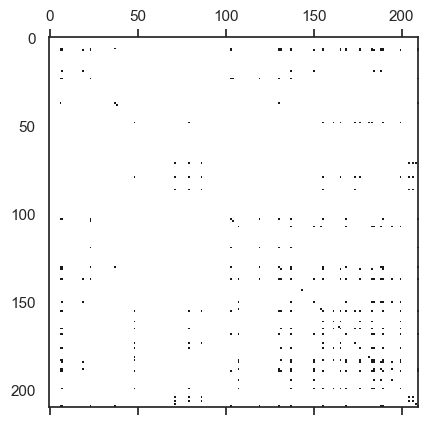

In [656]:
B_e = np.array([t.get_edges_prob(len(Xdf.columns)) for t in trees])
plt.spy(B_e.T@B_e)

In [595]:

# softmax(

# E_obs = squareform(np.abs((struct.T@struct).todense()), checks=False)
E_obs = np.array([t.get_edges_prob(len(Xdf.columns), degprior=False, pseudocts=0.1) 
                  for t in trees]).mean(axis=0)
def dirichlet_mult_like(cts, alpha=0.1):
    return (cts+alpha)/(cts+alpha).sum()

E_pmf = dirichlet_mult_like(E_obs)
# E_pmf = softmax(E_pmf+1)
E_obs
# (struct.T@struct).todense()
# _random_tree_jump(count,

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.16, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.18, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.  , 0.  , 0.06, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [647]:

est_dists = approx_dists(Xdf.values)
# est_dists = approx_dists(papers.values)

n_nodes = est_dists.shape[1]
trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in Xdf.values]
# trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in papers.values]

cutters = [cycle(range(t.incidence.shape[0])) for t in trees]

deps = []
nodeps=[]
hist = []
# i = 0
for it in trange(100):
    struct = sprs.vstack([t.upcast_incidence(len(Xdf.columns)) for t in trees])
    # struct = sprs.vstack([t.upcast_incidence(n_authors) for t in trees])

    E_obs = sq(np.abs((struct.T@struct).todense()))
    ## FIGURE OUT HOW TO USE L_SYM FOR THIS TO AVOID ROOT-DOMINANCE 
    ## (UNIFORM PRIOR ON DEGREE, I GUESS??)
     
    for cutter, t in list(zip(cutters, trees)):
        mask = t.get_edge_mask(n_nodes)
        edge_in_B = -sq(t.L())
        B_edges = np.where(edge_in_B)[0]

        e_cut = _random_cut(cutter, t.incidence, t.forest)
        
        E_obs[mask[B_edges[e_cut]]] -= 1
        E_pmf = dirichlet_mult_like(sq(t.Lsym()), alpha=0.1)
        if np.any(E_obs<0): 
            print(mask)
            print(squareform(t.incidence.T@t.incidence, checks=False))
            print(B_edges, mask[B_edges], E_obs[mask[B_edges]])
        e_add = _random_bridge(E_pmf[mask], t.forest)
        t.incidence[e_cut] = _std_incidence_vec(
            t.incidence.shape[1], 
            _e_to_ij(t.incidence.shape[1], e_add)
        )
        
        edge_in_B = -squareform(t.incidence.T@t.incidence, checks=False)
        B_edges = np.where(edge_in_B)[0]
        B_not_edges = np.where(np.logical_not(edge_in_B))[0]
        nodep=np.zeros_like(E_obs)
        dep = np.zeros_like(E_obs)

        dep[mask[B_edges]] = 1
        # nodep[mask[
        deps += [dep]
        E_obs[mask[e_add]] += 1
        hist += [E_obs]
        # i+=1

  0%|                                                   | 0/100 [00:00<?, ?it/s]


IndexError: index 136 is out of bounds for axis 0 with size 21

In [59]:
# hinton(sq(sq(ochiai(X))-np.array(deps).mean()))
# from scipy.stats import entropy
# entropy(sq(ochiai(X)), sq(outer(np.multiply,papers.sum().values/papers.shape[0])))

# plt.spy(L, marker='.')

SyntaxError: '(' was never closed (1210169449.py, line 4)

<Axes: >

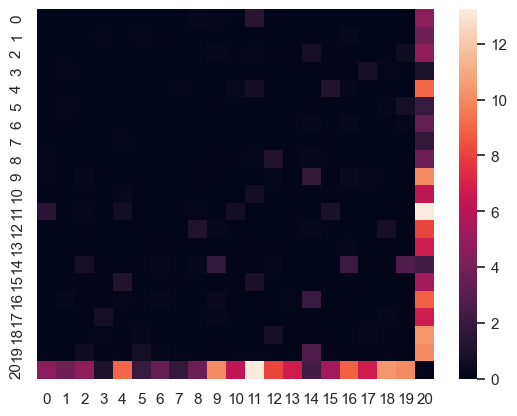

In [60]:

sns.heatmap(squareform(np.array(hist).mean(axis=0)))


<Axes: >

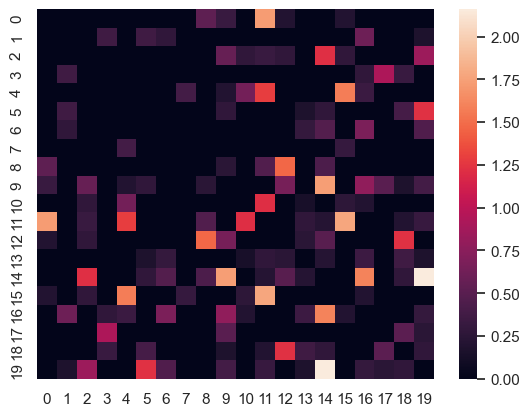

In [61]:
sns.heatmap(squareform(np.array(hist).std(axis=0)))

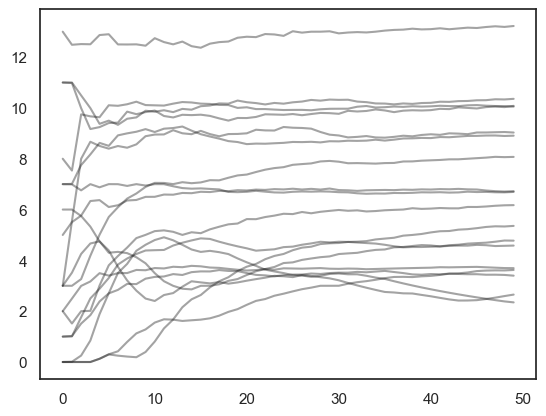

In [71]:
plt.plot(
    (np.array(hist).cumsum(axis=0).T/np.mgrid[1:5001])[
        np.array(hist).mean(axis=0)>2,:
    ].T[np.arange(0,5000,100)],
    color='k', alpha=0.4
);


In [148]:
_random_tree_jump(
    count(),
    E_pmf[trees[0].get_edge_mask(len(Xdf.columns))],
    trees[0].incidence, 
    trees[0].forest
)

# NOTE TO SELF: use random_cut and random_bridge, so you get the e_add and e_cut to directly put back in the 

array([[-1.,  1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [149]:
trees[0]

TreeDistribution(nodes=array([ 4,  8, 14, 15, 20]), incidence=array([[-1.,  1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  1.],
       [ 0.,  0.,  0., -1.,  1.]]), forest=array([[0.61818182, 0.23636364, 0.01818182, 0.03636364, 0.09090909],
       [0.23636364, 0.47272727, 0.03636364, 0.07272727, 0.18181818],
       [0.01818182, 0.03636364, 0.61818182, 0.23636364, 0.09090909],
       [0.03636364, 0.07272727, 0.23636364, 0.47272727, 0.18181818],
       [0.09090909, 0.18181818, 0.09090909, 0.18181818, 0.45454545]]))

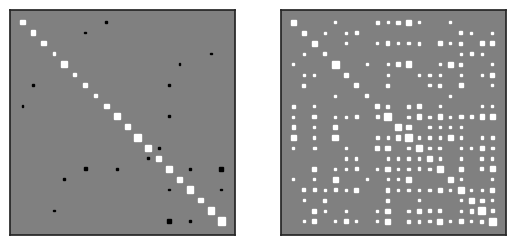

In [72]:
plt.subplot(121)
hinton((struct.T@struct).todense())
plt.subplot(122)
hinton(coocur_prob(papers.values))

## empirical bayes (legacy)

(i.e. the first EM step)

In [73]:
# papers

# dists = pd.DataFrame(squareform(pdist((metadf:=Xdf).T, metric='cosine')), columns=metadf.columns, index=metadf.columns)
dists = pd.DataFrame(approx_dists(metadf:=Xdf).values, columns=metadf.columns, index=metadf.columns)

# dists = pd.DataFrame(squareform(pdist((metadf:=Xdf).T.astype(int), metric='sqeuclidean')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(squareform(pdist((metadf:=Xdf).T.astype(int), metric='jaccard')), columns=metadf.columns, index=metadf.columns)

# dists =  pd.DataFrame(squareform(prox_to_edgeprob(sinkhorn(metadf.T@metadf - np.diag(metadf.sum().values), err=1e-8))), columns=metadf.columns, index=metadf.columns)
# dists.columns.get_loc('root')
# pd.DataFrame.nan_to_num
# dists = -np.log(resource_project(metadf))
# dists = np.sqrt(1-(1-dists)**2)

#.replace(np.inf, 0.)
# pd.DataFrame.fillna(
# shortest_path(dists, indices=[0,1,5])[:,[0,1,5]]
(dists+5*np.eye(21)).apply(np.argsort).apply(lambda x: np.where(x==20)[0]+1).loc[0]

author_01     4
author_02     6
author_03     6
author_04     8
author_05     3
author_06    12
author_07     6
author_08     7
author_09     4
author_10     3
author_11     4
author_12     5
author_13     4
author_14     1
author_15     6
author_16     4
author_17     3
author_18     3
author_19     1
author_20     5
root         21
Name: 0, dtype: int64

source     target   
author_01  author_09     2
author_02  author_04     1
           author_07     1
author_04  author_18     1
author_05  author_16     5
author_06  author_02     1
author_07  author_02     1
author_09  author_13     1
author_10  author_13     1
           author_15     1
author_12  author_01     5
           author_05     8
           author_11     5
           author_16     2
author_13  author_09     3
author_15  author_03     4
           author_10     4
           author_17     4
author_16  author_08     1
author_17  author_02     1
           author_07     3
           author_15     1
author_18  author_04     1
author_19  author_03     1
           author_13     4
           author_18     3
author_20  author_03     1
           author_06     3
           author_10     1
           author_15     6
root       author_01     1
           author_02     1
           author_05     2
           author_08     1
           author_10     6
           author_11     2
       

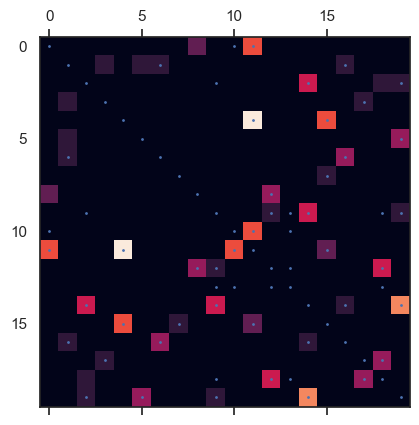

In [74]:

def estimate_mst_basis(x, dist:pd.DataFrame, root='root'):
    # A_x = A.loc[x, x]
    
    indices = dist.columns.get_indexer(x[x].index)
    # Dx, Pr = shortest_path(dist, indices=indices,return_predecessors=True)
    
    
    # D_x = dist.loc[x, x]
    # T_stein = breadth_first_tree(minimum_spanning_tree(D_x[:,indices]).tocoo(), len(indices)-1, directed=False)
    bft = breadth_first_tree(
        minimum_spanning_tree(dist.iloc[indices,indices]),
        # minimum_spanning_tree(Dx[:,indices]), 
        # dist.columns.get_loc(root), 
        len(indices)-1,
        directed=False
    ).tocoo()

    A1obs = pd.Series(
        True, index=pd.MultiIndex.from_arrays(
            (x[x].index[bft.row],x[x].index[bft.col]), 
            names=('source','target')
    ), name='weight').astype('Sparse[bool]')
    # src,tgt = (D_x.index[np.minimum(T_stein.row, T_stein.col)], # if you want strictly lower tri_diag
    #            D_x.index[np.maximum(T_stein.row, T_stein.col)])
    # src,tgt = (dist.index[indices[T_stein.row]], dist.index[indices[T_stein.col]])
    # yield from zip(repeat(xid),src,tgt)
    return A1obs
    # return pd.Series(1, index=pd.MultiIndex.from_arrays(
    #     [src, tgt], names=['source','target']), dtype='Sparse[int]', name='weight')

def stein_edge_approx(paths, edges, holdout='meta'): 
    for u,v in edges: 
        yield from (sorted(pair) for pair in sliding_window(2, paths[u][v])) 

# dists = pd.DataFrame(squareform(pdist((metadf:=Xdf).T, metric='sqeuclidean')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(squareform(pdist((metadf:=Xdf).T, metric='jaccard')), columns=metadf.columns, index=metadf.columns)


obs_edges = pd.concat([
    estimate_mst_basis(x[1], dist=dists)
    .to_frame()
    .assign(week=x[0]) 
    for x in metadf.astype(bool).iterrows()
])

L_mst= (
    obs_edges.astype('Sparse[int]')
    .groupby(['source','target'])['weight'].
    sum()
    #.unstack()
)
# L_mst = np.maximum(L_mst, L_mst.T)
L_mst=nx.to_pandas_adjacency(
    nx.from_pandas_edgelist(
        L_mst.reset_index(), edge_attr=True,
        # create_using=nx.DiGraph
    )).loc[author_idx, author_idx]

plt.imshow(L_mst)
plt.spy(L, marker='.', markersize=2)

# interp_dist(np.diag(L_mst.sum(axis=1))-L_mst)
# L_mst
obs_edges.astype('Sparse[int]').groupby(['source','target'])['weight'].sum()


In [75]:
(obs_edges
 .astype('Sparse[int]')
 .reset_index().set_index(['week','source','target'])['weight']
 .sparse.to_coo(row_levels=['week','source'], column_levels=['target'])[0]
 .todense()
 # .sum(axis=1)
)

/tmp/ipykernel_389238/1442011135.py:3: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  .reset_index().set_index(['week','source','target'])['weight']


matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

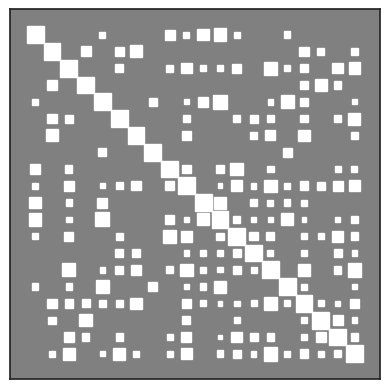

In [76]:
hinton(ochiai(papers.values))


/home/tbsexton/Sync/code/affinis/affinis/distance.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.log(Q / norm)


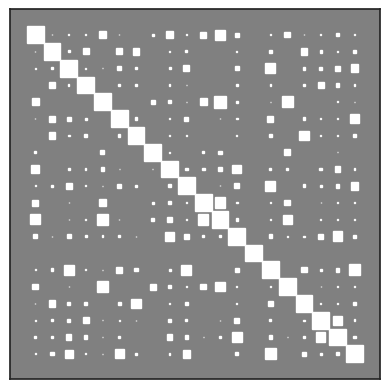

In [77]:
# obs_edges[obs_edges.index.get_level_values('source')=='root']['week'

hinton(np.exp(-generalized_graph_dists(np.diag(L_mst.sum())-L_mst, beta=0.2)))

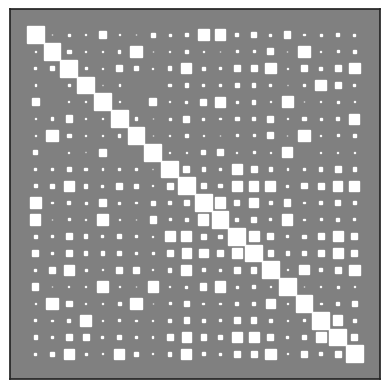

In [78]:
hinton(np.exp(-generalized_graph_dists(L)))

In [650]:
nx.draw(nx.from_pandas_adjacency(L_mst),pos=pos)

NameError: name 'L_mst' is not defined

In [80]:
true.shape[0]

190

In [213]:
IncidenceDtype = np.dtype(dict(names=author_idx.categories, formats=len(author_idx)*[np.int16]))
IncidenceDtype

IncidenceArrayDtype = np.dtype([('observation', [('incidences', IncidenceDtype)])])
IncidenceArrayDtype



dtype([('observation', [('incidences', [('author_01', '<i2'), ('author_02', '<i2'), ('author_03', '<i2'), ('author_04', '<i2'), ('author_05', '<i2'), ('author_06', '<i2'), ('author_07', '<i2'), ('author_08', '<i2'), ('author_09', '<i2'), ('author_10', '<i2'), ('author_11', '<i2'), ('author_12', '<i2'), ('author_13', '<i2'), ('author_14', '<i2'), ('author_15', '<i2'), ('author_16', '<i2'), ('author_17', '<i2'), ('author_18', '<i2'), ('author_19', '<i2'), ('author_20', '<i2')])])])

In [214]:
dists[metadf.iloc[2].astype(bool), metadf.iloc[2].astype(bool)]

InvalidIndexError: (author_01    False
author_02    False
author_03    False
author_04     True
author_05    False
author_06    False
author_07    False
author_08    False
author_09    False
author_10    False
author_11    False
author_12     True
author_13     True
author_14     True
author_15    False
author_16    False
author_17    False
author_18    False
author_19    False
author_20    False
root          True
Name: 2, dtype: bool, author_01    False
author_02    False
author_03    False
author_04     True
author_05    False
author_06    False
author_07    False
author_08    False
author_09    False
author_10    False
author_11    False
author_12     True
author_13     True
author_14     True
author_15    False
author_16    False
author_17    False
author_18    False
author_19    False
author_20    False
root          True
Name: 2, dtype: bool)

In [215]:
np.std(np.diag(cooc)),np.std(squareform(cooc-np.diag(np.diag(cooc))))

(0.046013199550476516, 0.027976494863396855)

In [216]:
forest(np.diag(L_mst.sum(axis=1))-L_mst)


array([[0.32270097, 0.        , 0.        , 0.08704139, 0.        ,
        0.        , 0.12781351, 0.15337621, 0.        , 0.        ,
        0.09678917, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07660494, 0.05722297, 0.0415328 , 0.03691804],
       [0.        , 0.28492334, 0.19352361, 0.        , 0.        ,
        0.04053121, 0.        , 0.        , 0.        , 0.04773676,
        0.        , 0.11525447, 0.06517161, 0.15588432, 0.04503468,
        0.05194   , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.19352361, 0.24217309, 0.        , 0.        ,
        0.04385344, 0.        , 0.        , 0.        , 0.05164961,
        0.        , 0.12470155, 0.07051355, 0.16866173, 0.04872605,
        0.05619737, 0.        , 0.        , 0.        , 0.        ],
       [0.08704139, 0.        , 0.        , 0.21849286, 0.        ,
        0.        , 0.09066811, 0.10880173, 0.        , 0.        ,
        0.14973191, 0.        , 0.        , 0

False

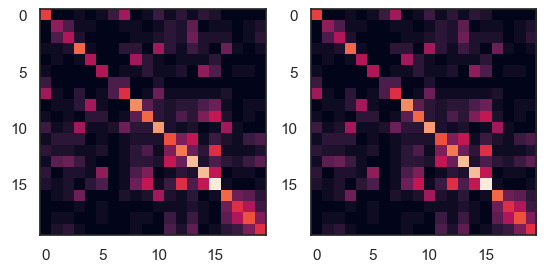

In [217]:
plt.subplot(1,2,1)
plt.imshow((np.einsum('bi,bo->bio', X, X)).sum(axis=0))
plt.subplot(1,2,2)
plt.imshow(cooc)

np.allclose((np.einsum('bi,bo->bio', X, X)).sum(axis=0),cooc)

In [218]:
prox_to_edgeprob((squareform(ys[2])*np.einsum('bi,bo->bio', X, X)).sum(axis=0))

array([0.00000000e+00, 0.00000000e+00, 2.75702626e-06, 0.00000000e+00,
       4.32071741e-21, 5.58043112e-02, 1.37617295e-01, 0.00000000e+00,
       3.01001450e-19, 7.68421312e-04, 1.07631130e-13, 4.57026415e-15,
       1.06190743e-13, 9.03006838e-19, 4.25319428e-17, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.97419808e-02,
       7.71176516e-12, 1.09174642e-13, 0.00000000e+00, 0.00000000e+00,
       1.06190743e-13, 7.60563883e-12, 0.00000000e+00, 7.60709872e-12,
       5.76423516e-04, 5.43916931e-06, 8.14494849e-02, 0.00000000e+00,
       3.79636326e-08, 5.37343896e-10, 0.00000000e+00, 2.71959216e-06,
       3.84282344e-04, 1.54235303e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.60563883e-12, 5.37342415e-10,
       1.52141974e-11, 5.76423516e-04, 5.43916931e-06, 9.50243990e-02,
       1.07468779e-09, 7.59272651e-08, 1.07468779e-09, 0.00000000e+00,
       2.71959216e-06, 5.76423516e-04, 3.09399992e-19, 0.00000000e+00,
      

<Axes: >

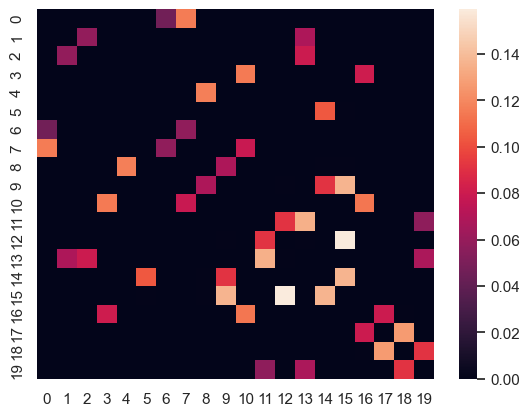

In [219]:
edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)*squareform(ys[1])).sum(axis=0))
sns.heatmap(squareform(edgenorm))

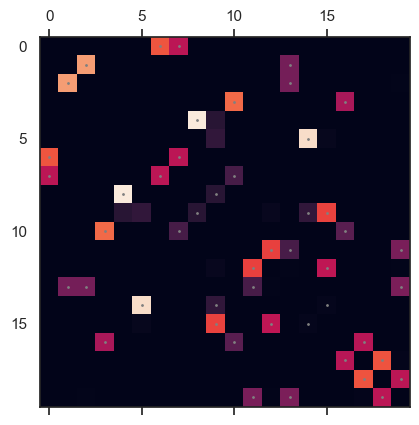

In [221]:
norm_fac = np.asarray(forest(L, beta=0.01))
# norm_fac=np.asarray(A)
# edgenorm=norm_adj((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac) # distributive
edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac)
plt.imshow(sinkhorn(squareform(edgenorm)))
plt.spy(L-np.diag(np.diag(L)), marker='.', markersize=2, color='grey')

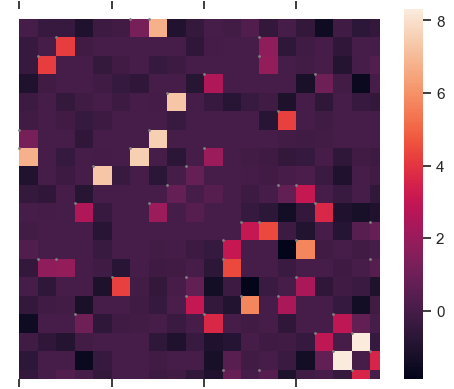

In [222]:

glasso=squareform(GraphicalLassoCV().fit(X).get_precision(), checks=False)

sns.heatmap(-squareform(glasso))
plt.spy(L-np.diag(np.diag(L)), marker='.', markersize=2, color='grey')
# glasso

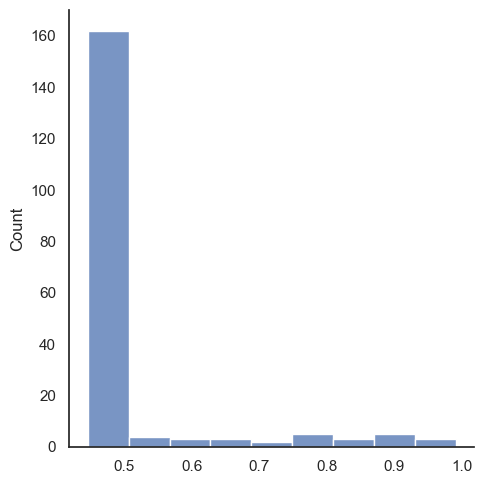

In [529]:
sns.displot(1/(1+np.exp(glasso)))

In [223]:

# sns.heatmap(Khat:=_prox_to_dists(sinkhorn(ochiai(np.block([[X,0],[np.eye(n_authors),-1]])))))
# np.block(
# np.searchsorted(
np.block([[X,np.ones(X.shape[0])],[np.eye(n_authors),-np.ones()]])
# for i in range(Khat.shape[0]):
    # print(np.searchsorted(Khat[i], Khat[i,-1], sorter=np.argsort(Khat)[i]))

TypeError: ones() missing 1 required positional argument: 'shape'

<Axes: >

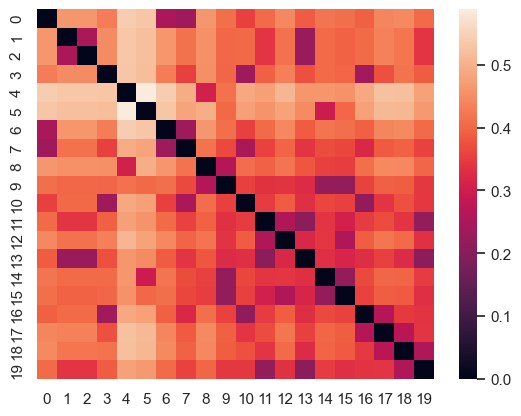

In [1040]:
sns.heatmap(adjusted_forest_dists(L, ))
# -np.log(forest(L)/np.sqrt(np.multiply.outer(np.diag(forest(L)),np.diag(forest(L)))))

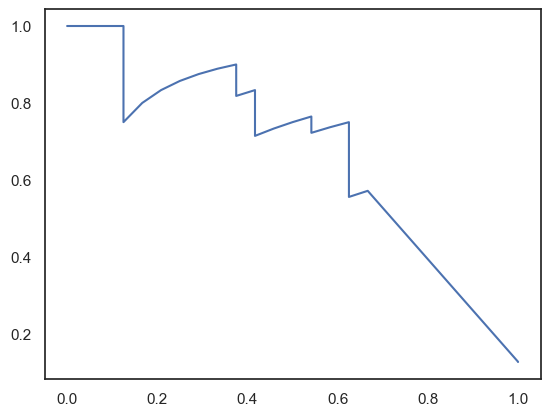

In [530]:
# p,r,t = precision_recall_curve(true, 1/(1+np.exp(-glasso)))
p,r,t = precision_recall_curve(true, 1/(1+np.exp(glasso)))

# p,r,t = precision_recall_curve(true, edgenorm)

plt.plot(r,p)
# plt.plot(r,p)
def penrose(p,r):
    return (np.tanh(p+r)-np.tanh(p-r),np.tanh(p+r)+np.tanh(p-r))
# plt.plot(*penrose(p,r))

In [382]:
glasso

array([ 1.80993592e-01, -0.00000000e+00,  0.00000000e+00,  2.29401877e-01,
        1.94949417e-02, -3.37789670e-01, -6.59070890e-01,  0.00000000e+00,
        5.65042506e-02, -0.00000000e+00,  3.93057983e-02,  0.00000000e+00,
       -5.61032201e-02,  1.19708305e-01,  9.16213969e-02,  1.39848663e-01,
        8.35793137e-02,  0.00000000e+00,  7.77531757e-02, -3.81160905e-01,
        0.00000000e+00,  1.34299150e-01, -3.25816069e-02, -4.13615347e-02,
        6.76621684e-03, -0.00000000e+00, -0.00000000e+00,  1.26779248e-02,
        0.00000000e+00,  6.88247037e-02, -3.10293824e-01,  5.64640635e-02,
       -0.00000000e+00,  6.87468238e-02,  1.95051959e-02,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.47578405e-02,
       -0.00000000e+00,  1.10332633e-01,  1.06921696e-01,  4.61456918e-02,
        3.42274721e-02,  0.00000000e+00,  3.01296495e-03, -2.93180161e-01,
        0.00000000e+00,  1.25512639e-01,  3.69366701e-02,  4.86703960e-02,
        1.31186053e-02,  

(array([0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758,
        0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758]),
 array([0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758,
        0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758]))

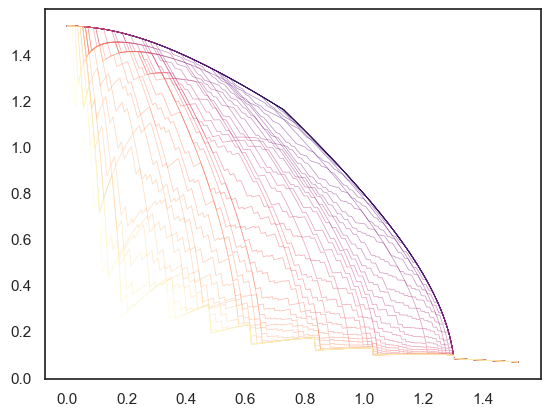

In [56]:
def penrose(p,r):
    return (np.tanh(p+r)-np.tanh(p-r),np.tanh(p+r)+np.tanh(p-r))

for bet,c in zip(x, color):
    norm_fac = np.asarray(forest(L, beta=bet))
    # norm_fac=np.asarray(A)
    # edgenorm=norm_adj((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac) # distributive
    edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)*norm_fac).sum(axis=0))
    
    p,r,t = precision_recall_curve(true, edgenorm)
    # plt.plot(r,p)?
    
    plt.plot(*penrose(p,r), color=c, alpha=.5, zorder=-1, lw=0.5)
    # print(t[0],t[-1])
    
# plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax = plt.gca(), values=x )
penrose(np.ones(10), np.ones(10))